While editing this notebook, don't change cell types as that confuses the autograder.

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [1]:
NAME = "Wei"

_Understanding Deep Learning_

---

<a href="https://colab.research.google.com/github/DL4DS/sp2024_notebooks/blob/main/release/nbs10/10_2_Convolution_for_MNIST_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 10.2: Convolution for MNIST-1D

This notebook investigates a 1D convolutional network for MNIST-1D as in figure 10.7 and 10.8a.

Adapted from notebooks at https://github.com/udlbook/udlbook.

In [2]:
# Clone the mnist1d repository if it doesn't exist
import os

if not os.path.exists('mnist1d'):
    !git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 204 (delta 47), reused 60 (delta 41), pack-reused 128
Receiving objects: 100% (204/204), 8.42 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [3]:
pip install torchinfo

In [4]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random
from torchinfo import summary

In [5]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [6]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Define the network

In [9]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# TODO Create a model with the following layers
# 1. Convolutional layer, (input=length 40 and 1 channel, kernel size 3, stride 2, padding="valid", 15 output channels )
# 2. ReLU
# 3. Convolutional layer, (input=length 19 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels )
# 4. ReLU
# 5. Convolutional layer, (input=length 9 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels)
# 6. ReLU
# 7. Flatten (converts 4x15) to length 60
# 8. Linear layer (input size = 60, output size = 10)
# References:
# https://pytorch.org/docs/1.13/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d
# https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html
# https://pytorch.org/docs/1.13/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear

# NOTE THAT THE CONVOLUTIONAL LAYERS NEED TO TAKE THE NUMBER OF INPUT CHANNELS AS A PARAMETER
# AND NOT THE INPUT SIZE.

# YOUR CODE HERE
model = nn.Sequential(
    nn.Conv1d(in_channels = 1, out_channels=15, kernel_size=3, stride=2, padding="valid"),
    nn.ReLU(),
    nn.Conv1d(in_channels = 15, out_channels=15, kernel_size=3, stride=2, padding="valid"),
    nn.ReLU(),
    nn.Conv1d(in_channels=15, kernel_size=3, stride=2, padding="valid", out_channels=15),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(60, 10))


In [10]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [11]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [12]:
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

In [13]:
print(len(data_loader))
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

40
4000
4000
1000
1000


In [14]:
# Initialize model weights
model.apply(weights_init)
print(model)
summary(model, input_size=(100, 1, 40))

Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(2,), padding=valid)
  (1): ReLU()
  (2): Conv1d(15, 15, kernel_size=(3,), stride=(2,), padding=valid)
  (3): ReLU()
  (4): Conv1d(15, 15, kernel_size=(3,), stride=(2,), padding=valid)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=60, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [100, 10]                 --
├─Conv1d: 1-1                            [100, 15, 19]             60
├─ReLU: 1-2                              [100, 15, 19]             --
├─Conv1d: 1-3                            [100, 15, 9]              690
├─ReLU: 1-4                              [100, 15, 9]              --
├─Conv1d: 1-5                            [100, 15, 4]              690
├─ReLU: 1-6                              [100, 15, 4]              --
├─Flatten: 1-7                           [100, 60]                 --
├─Linear: 1-8                            [100, 10]                 610
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
Total mult-adds (M): 1.07
Input size (MB): 0.02
Forward/backward pass size (MB): 0.39
Params size (MB): 0.01
Estimated Total Size (MB): 0.42

Epoch     0, train loss 1.941297, train error 74.28,  val loss 1.947611, percent error 75.70
Epoch     1, train loss 1.545876, train error 60.50,  val loss 1.590061, percent error 63.70
Epoch     2, train loss 1.365245, train error 56.70,  val loss 1.388014, percent error 57.40
Epoch     3, train loss 1.276698, train error 50.15,  val loss 1.271918, percent error 51.70
Epoch     4, train loss 1.180543, train error 46.97,  val loss 1.189901, percent error 50.10
Epoch     5, train loss 1.056210, train error 41.35,  val loss 1.071907, percent error 45.40
Epoch     6, train loss 1.049180, train error 42.97,  val loss 1.081201, percent error 46.60
Epoch     7, train loss 0.866958, train error 35.05,  val loss 0.910271, percent error 38.40
Epoch     8, train loss 0.718005, train error 29.68,  val loss 0.767064, percent error 31.30
Epoch     9, train loss 0.726588, train error 27.82,  val loss 0.785575, percent error 31.00
Epoch    10, train loss 0.646390, train error 25.12,  val loss 0.70958

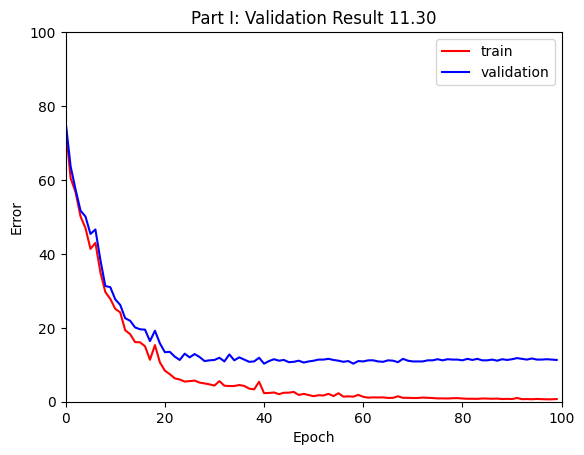

In [15]:

# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch[:,None,:])
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train[:,None,:])
  pred_val = model(x_val[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()

Compare the number of parameters from the model summary above and the test error
with the fully connected model in 8_1_MNIST_1D_Performance.ipynb.